<a href="https://colab.research.google.com/github/anushan1989/syntactic_processing_assingment/blob/main/Anusha_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying Entities in Healthcare Data

## Workspace set up: Import and Install useful packages.

In [74]:
!pip install pycrf
!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

## Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line.
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

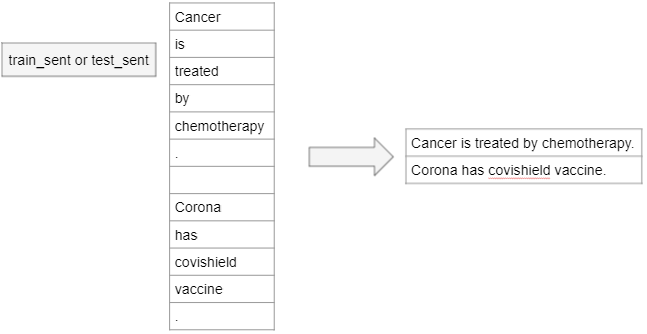

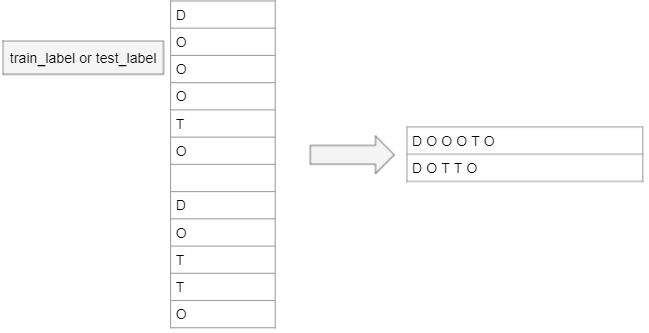

In [75]:
# Reading the train_sent,test_sent,train_label,test_label
with open('train_sent', 'r') as train_sent_file:
  train_words = train_sent_file.readlines()

with open('train_label', 'r') as train_labels_file:
  train_labels_words = train_labels_file.readlines()

with open('test_sent', 'r') as test_sent_file:
  test_words = test_sent_file.readlines()

with open('test_label', 'r') as test_labels_file:
  test_labels_words = test_labels_file.readlines()

In [76]:
print("Token count in training set", len(train_words))
print("Token count in training labels", len(train_labels_words))
print("Token count in test set", len(test_words))
print("Token count in test labels", len(test_labels_words))

Token count in training set 48501
Token count in training labels 48501
Token count in test set 19674
Token count in test labels 19674


In [77]:
def convert_to_sentences(dataset):
    sent_list = []
    sent = ""
    for entity in dataset:
        if entity != '\n':
            sent = sent + entity[:-1] + " "       # Adding word/label to current sentence / sequence of labels
        else:
            sent_list.append(sent[:-1])           # Getting rid of the space added after the last entity.
            sent = ""
    return sent_list

In [78]:
train_sentences = convert_to_sentences(train_words)

# print first 5 train sentences
for sentence in train_sentences[:5]:
    print("Train sentence : " + sentence)

Train sentence : All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
Train sentence : The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
Train sentence : Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
Train sentence : The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )
Train sentence : Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )


In [79]:
test_sentences = convert_to_sentences(test_words)

# print first 5 test sentences
for sentence in test_sentences[:5]:
    print("Test sentence : " + sentence)

Test sentence : Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )
Test sentence : As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration
Test sentence : The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period
Test sentence : There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )
Test sentence : Fluctuations in ambient temperature are inversely correlated to changes in AFI


### Count the number of sentences in the processed train and test dataset

In [80]:
print("Sentences count in train dataset", len(train_sentences))
print("Sentences count in test dataset", len(test_sentences))

Sentences count in train dataset 2599
Sentences count in test dataset 1056


### Count the number of lines of labels in the processed train and test dataset.

In [81]:
train_labels = convert_to_sentences(train_labels_words)
print("Sentences count in training labels", len(train_labels))

test_labels = convert_to_sentences(test_labels_words)
print("Sentences count in test labels", len(test_labels))

Sentences count in training labels 2599
Sentences count in test labels 1056


## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging.


In [82]:
# Creating a combined dataset from training and test sentences, since this is an Exploratory analysis.
total = train_sentences + test_sentences
print("Total number of sentences in train and test dataset : {}".format(len(total)))

Total number of sentences in train and test dataset : 3655


### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [83]:
noun_pron = []
pos_tag = []
for sentence in total:
    for token in model(sentence):
        if token.pos_ in ['NOUN', 'PROPN']:
           noun_pron.append(token.text)
           pos_tag.append(token.pos_)
print("Total number of tokens in train and test dataset with PoS tag of 'NOUN' or 'PROPN': {}".format(len(noun_pron)))

Total number of tokens in train and test dataset with PoS tag of 'NOUN' or 'PROPN': 24373


In [84]:
print("Total number of pos tags in train and test dataset with PoS tag of 'NOUN' or 'PROPN': {}".format(len(pos_tag)))

Total number of pos tags in train and test dataset with PoS tag of 'NOUN' or 'PROPN': 24373


### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [85]:
import pandas as pd
from nltk import FreqDist

word_frequency = FreqDist(noun_pron)
pd.DataFrame(word_frequency.most_common(25), columns=["Sentence", "Count"])

,Sentence,Count
0,patients,492
1,treatment,281
2,%,247
3,cancer,200
4,therapy,175
5,study,153
6,disease,141
7,cell,140
8,lung,116
9,group,94


## Defining features for CRF

list of features used:

- f1 = input word is in lower case;
- f2 = last 3 characters of word;
- f3 = last 2 characers of word;
- f4 = 1; if the word is in uppercase, 0 otherwise;
- f5 = 1; if word is a number; otherwise, 0
- f6= 1; if the word starts with a capital letter; otherwise, 0

extra feature: if pos > 0 :

- fx1 = prev_word to lower
- fx2 = prev_word is upper
- fx3 = prev_word is digits
- fx4 = prev_word starts with capital letter

else:

- fx1 = BEG(beginning of text)
- if pos reached end:
- fx1 = ENd(ending of text)


In [86]:
# Let's define the features to get the feature value for one word.
def getFeaturesForOneWord(sentence, pos):
    word = sentence[pos]

    features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    ]

    #Use the previous word also while defining features
    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(),
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
    ])
    # Mark the begining and the end words of a sentence correctly in the form of features.
    else:
        features.append('BEG') # feature to track begin of sentence

    if(pos == len(sentence)-1):
        features.append('END') # feature to track end of sentence

    return features

## Getting the features

### Write a code/function to get the features for a sentence

In [87]:
# Write a code to get features for a sentence.
def getFeaturesForOneSentence(sentence):
  sentence_list = sentence.split()
  return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]

In [88]:
# Write a code to get the labels for a sentence.
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
sample_sentence = train_sentences[1]
print(sample_sentence)

features = getFeaturesForOneSentence(sample_sentence)
features[2]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=cesarean',
 'word[-3:]=ean',
 'word[-2:]=an',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'prev_word.lower=total',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False']

In [89]:
sample_sentence = train_sentences[1]
print(sample_sentence)

features = getFeaturesForOneSentence(sample_sentence)
features[0]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=the',
 'word[-3:]=The',
 'word[-2:]=he',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=True',
 'BEG']

### Write a code/function to get the labels of a sentence

In [90]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset

In [91]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sentences]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sentences]

### Define the labels as the target variable for test and the train dataset

In [92]:
y_train = [getLabelsInListForOneSentence(label) for label in train_labels]
y_test = [getLabelsInListForOneSentence(label) for label in test_labels]

## Build the CRF Model

In [93]:
# Build the CRF model.
import sklearn_crfsuite
from sklearn_crfsuite import metrics

In [94]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)
crf.fit(X_train, y_train)

CRF(max_iterations=100)

In [95]:
!pip install eli5

####  Visualization weight using eli5

In [96]:
import eli5
# Show top 20 weights of model across all labels
eli5.show_weights(crf, top=20)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [97]:
y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [98]:
# Calculate the f1 score using the test data
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1_score)

F1 score: 0.9044158773940202


## Identifying Diseases and Treatments using Custom NER
We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.

### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

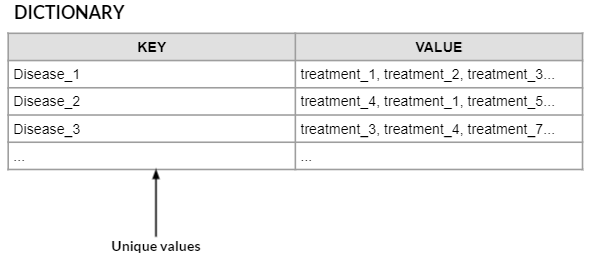

### Creating data frame for Disease and Treatments

In [99]:
import numpy as np
dataframe = pd.DataFrame([], columns=["Disease", "Treatments"])

import numpy as np
dataframe = pd.DataFrame([], columns=["Disease", "Treatments"])

for i in range(len(y_pred)):
  p_val = y_pred[i]
  dise = ""
  treat = ""

  DTO = set(p_val)
  if "D" in DTO and "T" in DTO:

    for j in range(len(p_val)):
      if p_val[j] == 'D':
        dise += test_sentences[i].split()[j] + " "
      elif p_val[j] == 'T':
        treat += test_sentences[i].split()[j] + " "

    dise = dise.strip()
    treat = treat.strip()

    present = dataframe.loc[(dataframe.Disease == dise), ["Disease"]]
    if present.size:
      treatment_df = dataframe.loc[(dataframe.Disease == dise), ["Treatments"]]
      treatment = treatment_df.values.tolist()
      treatment.extend([treat])
      dataframe.loc[(dataframe.Disease == dise), ["Treatments"]] = [[treatment]]

    else:
      dataframe = pd.concat([dataframe, pd.DataFrame([[dise, treat]], columns=dataframe.columns )])

dataframe = dataframe.set_index(np.arange(dataframe.shape[0]))
dataframe

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy
1,unstable angina or non-Q-wave myocardial infar...,roxithromycin
2,coronary-artery disease,Antichlamydial antibiotics
3,primary pulmonary hypertension ( PPH ),fenfluramines
4,cellulitis,G-CSF therapy intravenous antibiotic treatment
...,...,...
101,temporomandibular joint arthropathy,arthroscopic treatment
102,severe secondary peritonitis,Surgical management
103,hepatic metastases from colorectal cancer,Hepatic arterial infusion of chemotherapy afte...
104,Poliomyelitis prevention,live oral poliovirus vaccines


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [100]:
disease = 'hereditary retinoblastoma'
dataframe.loc[(dataframe.Disease == disease), ["Disease", "Treatments"]]

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy


## Model 2 : POS tag in feature

In [101]:
# Let's define the features to get the feature value for one word.
def getFeaturesForOneWord(sentence, pos, pos_tags):
    word = sentence[pos]

    features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    'word.pos=' + pos_tags[pos] # adding POS tag here
    ]

    #Use the previous word also while defining features
    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(),
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
        'prev_word.pos=' + pos_tags[pos-1] # adding POS tag here
    ])
    # Mark the begining and the end words of a sentence correctly in the form of features.
    else:
        features.append('BEG') # feature to track begin of sentence

    if(pos == len(sentence)-1):
        features.append('END') # feature to track end of sentence

    return features

In [102]:
# Function to get features for a sentence.
def getFeaturesForOneSentence(sentence):

    # We need to get the pos_tags to be passed to the function
    processed_sent = model(sentence)
    postags = []
    deptags = []

    for each_token in processed_sent:
        postags.append(each_token.pos_)
        deptags.append(each_token.dep_) # add dep

    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos, postags) for pos in range(len(sentence_list))]


In [103]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
sample_sentence = train_sentences[1]
print(sample_sentence)

features = getFeaturesForOneSentence(sample_sentence)
features[2]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=cesarean',
 'word[-3:]=ean',
 'word[-2:]=an',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word.pos=ADJ',
 'prev_word.lower=total',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False',
 'prev_word.pos=ADJ']

In [104]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
sample_sentence = train_sentences[1]
print(sample_sentence)

features = getFeaturesForOneSentence(sample_sentence)
features[0]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=the',
 'word[-3:]=The',
 'word[-2:]=he',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=True',
 'word.pos=DET',
 'BEG']

In [105]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

In [106]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sentences]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sentences]

#### Define the labels as the target variable for test and the train dataset

In [107]:
y_train = [getLabelsInListForOneSentence(label) for label in train_labels]
y_test = [getLabelsInListForOneSentence(label) for label in test_labels]

In [108]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)

In [109]:
crf.fit(X_train, y_train)

CRF(max_iterations=100)

####  Visualization weight using eli5

In [110]:
import eli5
# Show top 20 weights of model across all labels
eli5.show_weights(crf, top=20)

### Evaluation

#### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [111]:
y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [112]:
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1_score)

F1 score: 0.9073283958612477


### Creating Dataframe for Disease and Treatments

In [113]:
import numpy as np
dataframe = pd.DataFrame([], columns=["Disease", "Treatments"])

import numpy as np
dataframe = pd.DataFrame([], columns=["Disease", "Treatments"])

for i in range(len(y_pred)):
  p_val = y_pred[i]
  dise = ""
  treat = ""

  DTO = set(p_val)
  if "D" in DTO and "T" in DTO:

    for j in range(len(p_val)):
      if p_val[j] == 'D':
        dise += test_sentences[i].split()[j] + " "
      elif p_val[j] == 'T':
        treat += test_sentences[i].split()[j] + " "

    dise = dise.strip()
    treat = treat.strip()

    present = dataframe.loc[(dataframe.Disease == dise), ["Disease"]]
    if present.size:
      treatment_df = dataframe.loc[(dataframe.Disease == dise), ["Treatments"]]
      treatment = treatment_df.values.tolist()
      treatment.extend([treat])
      dataframe.loc[(dataframe.Disease == dise), ["Treatments"]] = [[treatment]]

    else:
      dataframe = pd.concat([dataframe, pd.DataFrame([[dise, treat]], columns=dataframe.columns )])

dataframe = dataframe.set_index(np.arange(dataframe.shape[0]))
dataframe

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy
1,myocardial infarction,"warfarin with 80 mg aspirin , or 1 mg warfarin..."
2,unstable angina or non-Q-wave myocardial infar...,roxithromycin
3,coronary-artery disease,Antichlamydial antibiotics
4,primary pulmonary hypertension ( PPH ),fenfluramines
...,...,...
106,temporomandibular joint arthropathy,arthroscopic treatment
107,severe secondary peritonitis,Surgical management
108,hepatic metastases from colorectal cancer,Hepatic arterial infusion of chemotherapy afte...
109,chronic renal failure,Epoetin


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [114]:
disease = 'hereditary retinoblastoma'
dataframe.loc[(dataframe.Disease == disease), ["Disease", "Treatments"]]

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy


## Model 3: Adding POS tag and Dependancy tag in feature

In [115]:
# Let's define the features to get the feature value for one word.

def getFeaturesForOneWord(sentence, pos, pos_tags, deptags):
    word = sentence[pos]

    features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    'word.pos=' + pos_tags[pos], # adding POS tag here
    'word.dep_=' + deptags[pos] # adding DEP tag here
    ]

    #Use the previous word also while defining features
    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(),
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
        'prev_word.pos=' + pos_tags[pos-1], # adding POS tag here
        'word.dep_=' + deptags[pos-1] # adding DEP tag here
    ])
    # Mark the begining and the end words of a sentence correctly in the form of features.
    else:
        features.append('BEG') # feature to track begin of sentence

    if(pos == len(sentence)-1):
        features.append('END') # feature to track end of sentence

    return features

In [116]:
# Function to get features for a sentence.
def getFeaturesForOneSentence(sentence):

    # We need to get the pos_tags to be passed to the function
    processed_sent = model(sentence)
    postags = []
    deptags = []

    for each_token in processed_sent:
        postags.append(each_token.pos_)
        deptags.append(each_token.dep_) # add dep

    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos, postags, deptags) for pos in range(len(sentence_list))]

In [117]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sentences[1]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[2]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=cesarean',
 'word[-3:]=ean',
 'word[-2:]=an',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word.pos=ADJ',
 'word.dep_=amod',
 'prev_word.lower=total',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False',
 'prev_word.pos=ADJ',
 'word.dep_=amod']

In [118]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
sample_sentence = train_sentences[1]
print(sample_sentence)

features = getFeaturesForOneSentence(sample_sentence)
features[0]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=the',
 'word[-3:]=The',
 'word[-2:]=he',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=True',
 'word.pos=DET',
 'word.dep_=det',
 'BEG']

In [119]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

In [120]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sentences]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sentences]

### Define the labels as the target variable for test and the train dataset

In [121]:
y_train = [getLabelsInListForOneSentence(label) for label in train_labels]
y_test = [getLabelsInListForOneSentence(label) for label in test_labels]

In [122]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)

In [123]:
crf.fit(X_train, y_train)

CRF(max_iterations=100)

####  Visualization weight using eli5

In [124]:
import eli5
# Show top 20 weights of model across all labels
eli5.show_weights(crf, top=20)

### Evaluation
#### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [125]:
y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [126]:
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1_score)

F1 score: 0.9050879539751051


### Creating Dataframe for Disease and Treatments

In [127]:
import numpy as np
dataframe = pd.DataFrame([], columns=["Disease", "Treatments"])

import numpy as np
dataframe = pd.DataFrame([], columns=["Disease", "Treatments"])

for i in range(len(y_pred)):
  p_val = y_pred[i]
  dise = ""
  treat = ""

  DTO = set(p_val)
  if "D" in DTO and "T" in DTO:

    for j in range(len(p_val)):
      if p_val[j] == 'D':
        dise += test_sentences[i].split()[j] + " "
      elif p_val[j] == 'T':
        treat += test_sentences[i].split()[j] + " "

    dise = dise.strip()
    treat = treat.strip()

    present = dataframe.loc[(dataframe.Disease == dise), ["Disease"]]
    if present.size:
      treatment_df = dataframe.loc[(dataframe.Disease == dise), ["Treatments"]]
      treatment = treatment_df.values.tolist()
      treatment.extend([treat])
      dataframe.loc[(dataframe.Disease == dise), ["Treatments"]] = [[treatment]]

    else:
      dataframe = pd.concat([dataframe, pd.DataFrame([[dise, treat]], columns=dataframe.columns )])

dataframe = dataframe.set_index(np.arange(dataframe.shape[0]))
dataframe

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy
1,myocardial infarction,"aspirin , 3 mg warfarin with 80 mg aspirin , o..."
2,unstable angina,roxithromycin
3,coronary-artery disease,Antichlamydial antibiotics
4,essential hypertension,moxonidine
...,...,...
97,temporomandibular joint arthropathy,arthroscopic treatment
98,severe secondary peritonitis,Surgical management
99,hepatic metastases from colorectal cancer,Hepatic arterial infusion of chemotherapy afte...
100,chronic renal failure,Epoetin


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [128]:
disease = 'hereditary retinoblastoma'
dataframe.loc[(dataframe.Disease == disease), ["Disease", "Treatments"]]

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy


## Model 4: max_iterations to 500

In [129]:
# Let's define the features to get the feature value for one word.

def getFeaturesForOneWord(sentence, pos, pos_tags, deptags):
    word = sentence[pos]

    features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    'word.pos=' + pos_tags[pos], # adding POS tag here
    'word.dep_=' + deptags[pos] # adding DEP tag here
    ]

    #Use the previous word also while defining features
    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(),
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
        'prev_word.pos=' + pos_tags[pos-1], # adding POS tag here
        'word.dep_=' + deptags[pos-1] # adding DEP tag here
    ])
    # Mark the begining and the end words of a sentence correctly in the form of features.
    else:
        features.append('BEG') # feature to track begin of sentence

    if(pos == len(sentence)-1):
        features.append('END') # feature to track end of sentence

    return features


In [130]:
# Function to get features for a sentence.
def getFeaturesForOneSentence(sentence):

    # We need to get the pos_tags to be passed to the function
    processed_sent = model(sentence)
    postags = []
    deptags = []

    for each_token in processed_sent:
        postags.append(each_token.pos_)
        deptags.append(each_token.dep_) # add dep

    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos, postags, deptags) for pos in range(len(sentence_list))]


In [131]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
sample_sentence = train_sentences[1]
print(sample_sentence)

features = getFeaturesForOneSentence(sample_sentence)
features[2]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=cesarean',
 'word[-3:]=ean',
 'word[-2:]=an',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word.pos=ADJ',
 'word.dep_=amod',
 'prev_word.lower=total',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False',
 'prev_word.pos=ADJ',
 'word.dep_=amod']

In [132]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
sample_sentence = train_sentences[1]
print(sample_sentence)

features = getFeaturesForOneSentence(sample_sentence)
features[0]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=the',
 'word[-3:]=The',
 'word[-2:]=he',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=True',
 'word.pos=DET',
 'word.dep_=det',
 'BEG']

In [133]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

In [134]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sentences]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sentences]

### Define the labels as the target variable for test and the train dataset

In [135]:
y_train = [getLabelsInListForOneSentence(label) for label in train_labels]
y_test = [getLabelsInListForOneSentence(label) for label in test_labels]

In [136]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=500)

In [137]:
crf.fit(X_train, y_train)

CRF(max_iterations=500)

####  Visualization weight using eli5

In [138]:
import eli5
# Show top 20 weights of model across all labels
eli5.show_weights(crf, top=20)

### Evaluation
#### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [139]:
y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [140]:
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1_score)

F1 score: 0.9127700864467786


- From above model we can see the accuracy has been increased to 91%

### Creating Dataframe for Disease and Treatments

In [141]:
import numpy as np
dataframe = pd.DataFrame([], columns=["Disease", "Treatments"])

import numpy as np
dataframe = pd.DataFrame([], columns=["Disease", "Treatments"])

for i in range(len(y_pred)):
  p_val = y_pred[i]
  dise = ""
  treat = ""

  DTO = set(p_val)
  if "D" in DTO and "T" in DTO:

    for j in range(len(p_val)):
      if p_val[j] == 'D':
        dise += test_sentences[i].split()[j] + " "
      elif p_val[j] == 'T':
        treat += test_sentences[i].split()[j] + " "

    dise = dise.strip()
    treat = treat.strip()

    present = dataframe.loc[(dataframe.Disease == dise), ["Disease"]]
    if present.size:
      treatment_df = dataframe.loc[(dataframe.Disease == dise), ["Treatments"]]
      treatment = treatment_df.values.tolist()
      treatment.extend([treat])
      dataframe.loc[(dataframe.Disease == dise), ["Treatments"]] = [[treatment]]

    else:
      dataframe = pd.concat([dataframe, pd.DataFrame([[dise, treat]], columns=dataframe.columns )])

dataframe = dataframe.set_index(np.arange(dataframe.shape[0]))
dataframe

,Disease,Treatments
0,cancer hereditary retinoblastoma,radiotherapy
1,unstable angina or non-Q-wave myocardial infar...,roxithromycin
2,coronary-artery disease,Antichlamydial antibiotics
3,primary pulmonary hypertension ( PPH ),fenfluramines
4,essential hypertension,moxonidine
...,...,...
106,temporomandibular joint arthropathy,arthroscopic treatment
107,severe secondary peritonitis,Surgical management
108,hepatic metastases from colorectal cancer,Hepatic arterial infusion of chemotherapy afte...
109,epithelial ovarian cancer,High-dose chemotherapy


### Predict the treatment for the disease name: 'epithelial ovarian cancer'

In [145]:
disease = 'epithelial ovarian cancer'
dataframe.loc[(dataframe.Disease == disease), ["Disease", "Treatments"]]

,Disease,Treatments
109,epithelial ovarian cancer,High-dose chemotherapy
